### Делаем все необходимые в задании импорты.

In [118]:
import pandas as pd
import numpy as np
import statsmodels as sm
import matplotlib.pyplot as plt
from scipy import stats

### Посмотрим на данные, преобразовав их к датафрейму

In [119]:
# Считываем данные из xlsx файла
file_path = "data.xlsx"
df = pd.read_excel(file_path)

# Выводим содержимое датафрейма на экран
print(df.head(20))

    user_id        cheks
0         1  1087.861666
1         1  1069.716544
2         2  1503.019248
3         2  1516.258353
4         2  1520.688252
5         2  1501.164315
6         2  1495.774702
7         2  1497.866709
8         3  1853.028817
9         3  1836.360939
10        3  1847.598004
11        3  1843.622059
12        4  1775.672463
13        4  1762.722783
14        4  1758.557628
15        5  1651.825055
16        5  1638.030745
17        5  1662.424616
18        5  1650.906179
19        5  1641.501008


### Фиксируем количество тестов, формируем необходимые датафреймы.

In [120]:
num_tests = 1000

# Создаем новый DataFrame для среднего чека по каждому пользователю
df_user_mean_ckeck = df.groupby('user_id').agg({'cheks':'mean'}).reset_index()
print(df_user_mean_ckeck.head(8))

# Создаем новый DataFrame для количества чеков каждого пользователя
df_user_ckecks_count = df.groupby('user_id').agg({'cheks':'count'}).reset_index()
print(df_user_ckecks_count.head(8))

# Создаем новый DataFrame для общей суммы чеков каждого пользователя
df_user_ckecks_sum = df.groupby('user_id').agg({'cheks':'sum'}).reset_index()
print(df_user_ckecks_sum.head(8))

   user_id        cheks
0        1  1078.789105
1        2  1505.795263
2        3  1845.152455
3        4  1765.650958
4        5  1648.937521
5        6  1836.942377
6        7  1693.892084
7        8  1124.545376
   user_id  cheks
0        1      2
1        2      6
2        3      4
3        4      3
4        5      5
5        6      5
6        7      4
7        8     13
   user_id         cheks
0        1   2157.578209
1        2   9034.771578
2        3   7380.609819
3        4   5296.952874
4        5   8244.687603
5        6   9184.711887
6        7   6775.568335
7        8  14619.089893


### Задание 1

Проверить, что распределение p-value на А/А-тестах для среднего чека (глобальное среднее) в по-юзерном тесте далеко не идеально в t-критерии, сделать вывод о применимости t-тест.

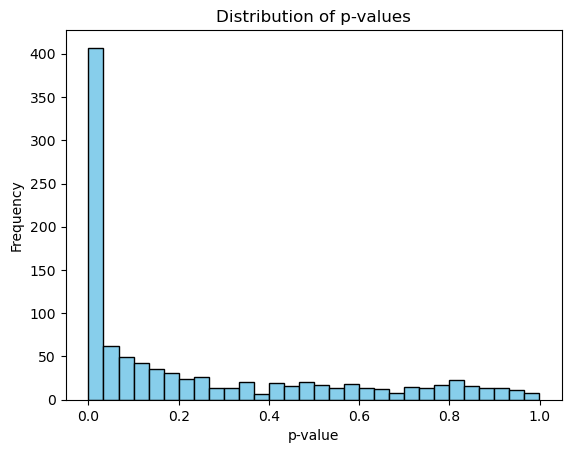

In [121]:
p_values = []

for _ in range(num_tests):
    # Случайным образом выбираем уникальных пользователей
    unique_users = df['user_id'].unique()
    np.random.shuffle(unique_users)
    half_len = len(unique_users) // 2
    
    # Выбираем пользователей для группы A и B
    users_A = unique_users[:half_len]
    users_B = unique_users[half_len:]
    
    # Разбиваем исходную выборку на две подвыборки по выбранным пользователям
    group_A = df[df['user_id'].isin(users_A)]
    group_B = df[df['user_id'].isin(users_B)]
    
    # Проводим t-тест для среднего чека на уровне пользователя
    result = sm.stats.weightstats.ttest_ind(group_A['cheks'], group_B['cheks'])
    
    # Извлекаем p-value из результата теста и добавляем его в список
    p_value = result[1]
    p_values.append(p_value)

# Выводим гистограмму распределения p-value
plt.hist(p_values, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of p-values')
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.show()


Вывод: как мы видим, значение p-value часто бывает близким к нулю, что означает, что наша гипотеза о равенстве средних с очень высокой вероятностью неверна.

### Задание 2

Проверить через распределение p-value на А/А-тестах, работает ли дельта-метод для глобального среднего.

Я не понял формулировки задания и как это сделать, поэтому обратился к помощи Интернета. Там нашел статью на хабре от X5 и адаптировал их решение под свой код. Я не уверен в правильности того, что сделал, но надеюсь, что понял как надо.

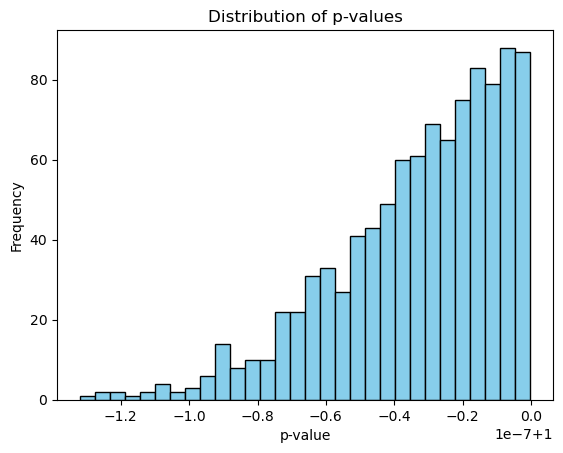

In [130]:
p_values = []

for _ in range(num_tests):
    # Случайным образом выбираем уникальных пользователей
    unique_users = df['user_id'].unique()
    np.random.shuffle(unique_users)
    half_len = len(unique_users) // 2
    
    # Выбираем пользователей для группы A и B
    users_A = unique_users[:half_len]
    users_B = unique_users[half_len:]
    
    # Разбиваем исходную выборку на две подвыборки по выбранным пользователям
    group_A = df_user_ckecks_sum[df_user_ckecks_sum['user_id'].isin(users_A)]
    group_B = df_user_ckecks_sum[df_user_ckecks_sum['user_id'].isin(users_B)]
    
    dict_ = {}
    for data_, group_name_ in [(group_A, 'A'), (group_B, 'B')]:
        array_x = data_['cheks'].to_numpy()
        array_y = df_user_ckecks_count[df_user_ckecks_count['user_id'].isin(users_A if group_name_ == 'A' else users_B)]['cheks'].to_numpy()
        
        # Считаем средний общий чек и среднее количество заказов по каждому пользователю
        mean_x, mean_y = np.mean(array_x), np.mean(array_y)
        
        # Аналогично с STD
        var_x, var_y = np.var(array_x), np.var(array_y)
        
        # Считаем ковариацию между общим чеком и количеством заказов
        cov_xy = np.cov(array_x, array_y)[0, 1]
        
        # Считаем точечную оценку метрики
        pe_metric = np.sum(array_x) / np.sum(array_y)
        
        # Вычисляем по формуле оценку дисперсии метрики
        var_metric = (
            var_x / mean_y ** 2
            - 2 * (mean_x / mean_y ** 3) * cov_xy
            + (mean_x ** 2 / mean_y ** 4) * var_y
        ) / len(data_)
        
        dict_[f'pe_metric_{group_name_}'] = pe_metric
        dict_[f'var_metric_{group_name_}'] = var_metric
        
    delta = dict_['pe_metric_B'] - dict_['pe_metric_A']
    var = dict_['var_metric_A'] + dict_['var_metric_B']
    t = delta / np.sqrt(var)
    
    p_value = (1 - stats.norm.cdf(np.abs(t), 0, np.var(df_user_ckecks_sum['cheks'].to_numpy()))) * 2 # здесь вообще не уверен - просто написал формулу на ощущениях
    p_values.append(p_value)

# Выводим гистограмму распределения p-value
plt.hist(p_values, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of p-values')
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.show()

Получилось что-то странное :( Буду смотреть разбор, но было бы круто, если бы Вы объяснили мне, где именно я не прав и можно ли несильно подправить мой код, чтобы он заработал корректно?

### Задание 3

Проверить аналогично прошлым пунктам применимость t-теста для нормализованного (двойного) среднего.

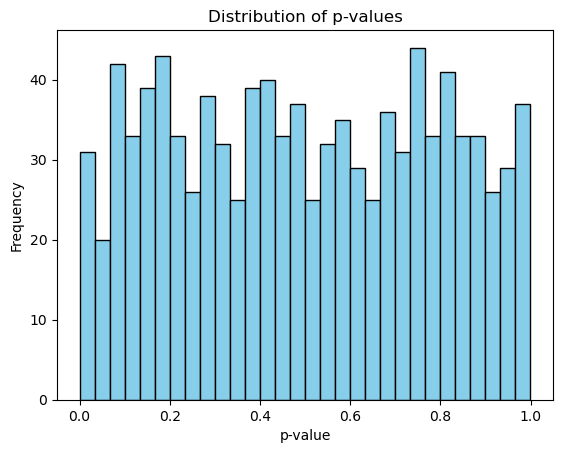

In [112]:
p_values = []

for _ in range(num_tests):
    # Разбиваем исходную выборку на две подвыборки случайным образом
    group_A = df_user_mean_ckeck.sample(frac=0.5)  # 50% данных
    group_B = df_user_mean_ckeck.drop(group_A.index)  # Оставшиеся 50% данных
    
    # Проводим t-тест для среднего чека на уровне пользователя
    result = sm.stats.weightstats.ttest_ind(group_A['cheks'], group_B['cheks'])
    
    # Извлекаем p-value из результата теста и добавляем его в список
    p_value = result[1]
    p_values.append(p_value)

# Выводим гистограмму распределения p-value
plt.hist(p_values, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of p-values')
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.show()


Вывод: здесь распределение получилось практически равномерным, что означает, что наша гипотеза верна и все выбросы случайны, то есть t-test стабилен.

### Задание 4

Сделать симуляции А/А-тестов таким образом – сгенерить эффект для таргетной группы так, чтобы среднее у него было 0, а дисперсия какая-то ненулевая. Проверить, что нормализованное среднее все еще стабильно в t-тесте.

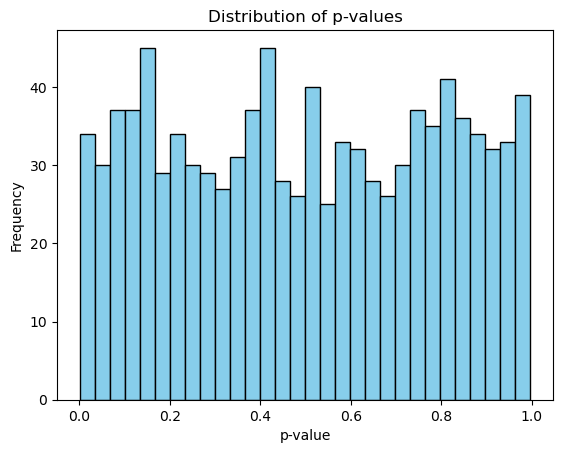

In [113]:
p_values = []

for _ in range(num_tests):
    # Разбиваем исходную выборку на две подвыборки случайным образом
    group_A = df_user_mean_ckeck.sample(frac=0.5)  # 50% данных
    group_B = df_user_mean_ckeck.drop(group_A.index)  # Оставшиеся 50% данных
    
    # Добавим случайный эффект к группе B
    group_B['cheks'] = group_B['cheks'] + np.random.normal(0, 5, len(group_B))
    
    # Проводим t-тест для среднего чека на уровне пользователя
    result = sm.stats.weightstats.ttest_ind(group_A['cheks'], group_B['cheks'])
    
    # Извлекаем p-value из результата теста и добавляем его в список
    p_value = result[1]
    p_values.append(p_value)

# Выводим гистограмму распределения p-value
plt.hist(p_values, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of p-values')
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.show()

Вывод: как мы видим, t-test всё ещё стабилен.

### Задание 5

Аналогично предыдущему пункту сгенерить эффект для таргетной группы так, чтобы среднее у него было 0 и не-нулевая дисперсия, но при этом средний эффект на пользователя был  скоррелирован с кол-вом заказов. Проверить, работает ли t-тест для нормализованного среднего

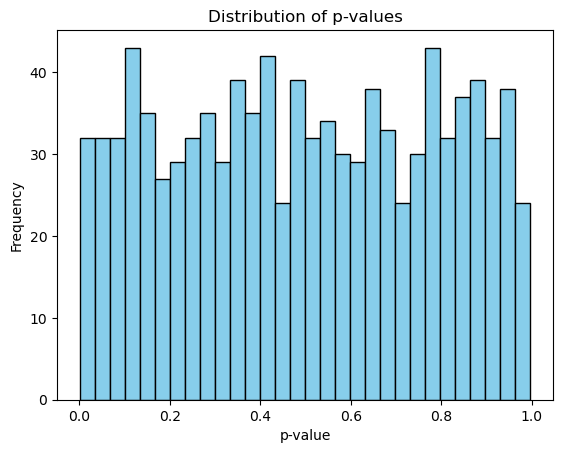

In [114]:
p_values = []

for _ in range(num_tests):
    # Разбиваем исходную выборку на две подвыборки случайным образом
    group_A = df_user_mean_ckeck.sample(frac=0.5)  # 50% данных
    group_B = df_user_mean_ckeck.drop(group_A.index)  # Оставшиеся 50% данных
    
    # Добавим случайный эффект к группе B
    group_B['cheks'] = group_B['cheks'] + np.random.normal(0, 5, len(group_B)) * df_user_ckecks_count[df_user_ckecks_count['user_id'].isin(group_B['user_id'])]['cheks'] ** 2
    
    # Проводим t-тест для среднего чека на уровне пользователя
    result = sm.stats.weightstats.ttest_ind(group_A['cheks'], group_B['cheks'])
    
    # Извлекаем p-value из результата теста и добавляем его в список
    p_value = result[1]
    p_values.append(p_value)

# Выводим гистограмму распределения p-value
plt.hist(p_values, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of p-values')
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.show()

Вывод: в таком случае также видно, что t-test стабилен, то есть нормализированное среднее можно использовать для A/B тестирования!